In [1]:
import utilities as utils


    Last Execution: 2022-04-03 09:19:00.014574
    python:	3.8.5

    	fastai:		2.5.6
    	matplotlib:	3.5.1
    	numpy:		1.19.5
    	pandas:		1.4.1
    	seaborn:	0.11.2
    	sklearn:	1.0.2
    	torch:		1.11.0+cu102
    	yellowbrick:	1.4
    	imblearn:	0.9.0
    


In [2]:
# This code is used to scale to processing numerous datasets
data_path_1: str = '../../../Data/phase1/'   

data_set_1: list = [ 'Darknet_reduced_features.csv' ]

data_set: list  = data_set_1
file_path_1      = utils.get_file_path(data_path_1)
file_set: list   = list(map(file_path_1, data_set_1))
current_job: int = 0

utils.data_set = data_set
utils.file_set = file_set


In [3]:
print(f'We will be cleaning {len(file_set)} files:')
utils.pretty(file_set)

We will be cleaning 1 files:
[   '../../../Data/phase1/Darknet_reduced_features.csv']


## Label Analysis

Now we load the data and separate the dataset by label, giving us a traffic dataset and an application dataset. We also want to investigate how merging the Non-Tor and NonVNP labels together affects the clustering, so rename the samples under these labels as regular and produce a second traffic dataset with it.

In [4]:

dataset : dict = utils.examine_dataset(1)
dataset = utils.package_data_for_inspection_with_label(
                utils.reduce_feature_to_values(dataset['Dataset'], 'Traffic Type', ['Tor', 'VPN', 'Non-Tor'] ), 'Dataset_2')

dataset['Dataset'] = utils.rename_values_in_column(dataset, [('Traffic Type', {'Non-Tor': 'Regular'})])

traffic_dataset : dict = utils.package_data_for_inspection_with_label(
                         utils.prune_dataset(dataset, ['Application Type']), 'Traffic_Dataset_2_Tor_VPN_Regular')

application_dataset : dict = utils.package_data_for_inspection_with_label(
                            utils.prune_dataset(dataset, ['Traffic Type']), 'Application_Dataset_1')

Dataset 1/1: We now look at ../../../Data/phase1/Darknet_reduced_features.csv


Loading Dataset: ../../../Data/phase1/Darknet_reduced_features.csv
	To Dataset Cache: ./cache/Darknet_reduced_features.csv.pickle


        File:				../../../Data/phase1/Darknet_reduced_features.csv  
        Job Number:			1
        Shape:				(141481, 64)
        Samples:			141481 
        Features:			64
    


/home/drake/projects/Sp22/CMUDarknet/experiments/data_generation/SMOTE/utilities.py:601: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(df[df[column] == v].copy())
/home/drake/projects/Sp22/CMUDarknet/experiments/data_generation/SMOTE/utilities.py:601: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(df[df[column] == v].copy())
/home/drake/projects/Sp22/CMUDarknet/experiments/data_generation/SMOTE/utilities.py:601: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(df[df[column] == v].copy())



        Shape:				(117620, 64)
        Samples:			117620 
        Features:			64
    

        Shape:				(117620, 63)
        Samples:			117620 
        Features:			63
    

        Shape:				(117620, 63)
        Samples:			117620 
        Features:			63
    


# SMOTE Prototype

Here we load up our first SMOTE model and train it on the whole traffic dataset. This way we have some data to play around with it and our actual splits will be done later.

In [5]:
def create_and_visualize_smote(df: utils.pd.DataFrame, target_label: str, ratio_dict: dict) -> list:
    '''
        Function creates and visualizes SMOTE with the given ratio
        Parameters:
            df: dataframe to be used for SMOTE
            target_label: the label used for prediction
            ratio_dict: dictionary of the ratio to be used for SMOTE for each class
    '''
    
    X = df.drop(target_label, axis=1)
    y = df[target_label]
    model = utils.SMOTE(sampling_strategy=ratio_dict)
    X, y = model.fit_resample(X, y)
    counter = utils.Counter(y)
    for k,v in counter.items():
        per = v / len(y) * 100
        print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
        
    # plot the distribution
    utils.pyplot.bar(counter.keys(), counter.values())
    utils.pyplot.show()
    return utils.pd.concat([X, utils.pd.DataFrame(y)], axis=1)

def get_largest_class_sample_size(df: utils.pd.DataFrame, column_name: str) -> int:
    '''
        Function returns the largest class sample size
    '''
    return df.groupby(column_name).size().max()



Class=Tor, n=93309 (33.333%)
Class=VPN, n=93309 (33.333%)
Class=Regular, n=93309 (33.333%)


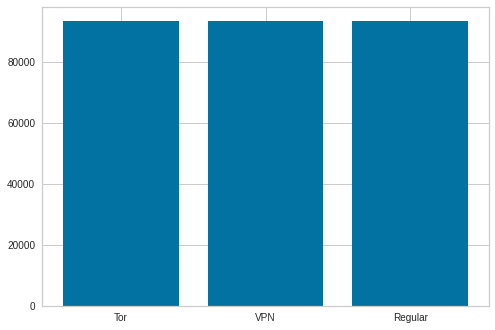

In [34]:
largest_class = get_largest_class_sample_size(traffic_dataset['Dataset'], 'Traffic Type')
ratio_dict = {"VPN": largest_class, "Regular": largest_class, "Tor": largest_class}
fake_df_traffic = create_and_visualize_smote(traffic_dataset['Dataset'], 'Traffic Type', ratio_dict)

Class=audio-streaming, n=48520 (12.500%)
Class=browsing, n=48520 (12.500%)
Class=chat, n=48520 (12.500%)
Class=file-transfer, n=48520 (12.500%)
Class=email, n=48520 (12.500%)
Class=p2p, n=48520 (12.500%)
Class=video-streaming, n=48520 (12.500%)
Class=voip, n=48520 (12.500%)


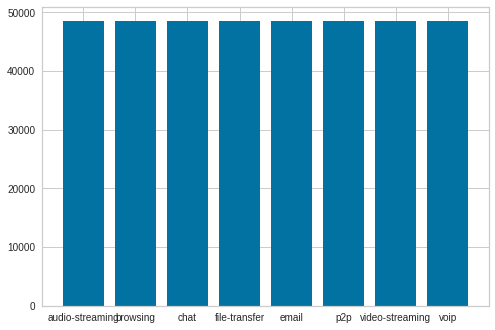

In [35]:
largest_class = get_largest_class_sample_size(application_dataset['Dataset'], 'Application Type')
ratio_dict = {"audio-streaming": largest_class, "browsing": largest_class, "chat": largest_class, "email": largest_class, "file-transfer": largest_class, "p2p": largest_class, "video-streaming": largest_class, "voip": largest_class}
fake_df_application = create_and_visualize_smote(application_dataset['Dataset'], 'Application Type', ratio_dict)

In [36]:
fake_traffic_dataset: dict = utils.package_data_for_inspection_with_label(
    utils.prune_dataset(utils.package_data_for_inspection(fake_df_traffic), [] ), 
    'smote_balanced_traffic_dataset_labels_equal'
)

fake_application_dataset: dict = utils.package_data_for_inspection_with_label(
    utils.prune_dataset(utils.package_data_for_inspection(fake_df_application), [] ), 
    'smote_balanced_application_dataset_labels_equal'
)


    Dataset statistics:
        Shape:				(279927, 63)
        Samples:			279927 
        Features:			63
    

        Shape:				(279927, 63)
        Samples:			279927 
        Features:			63
    

    Dataset statistics:
        Shape:				(388160, 63)
        Samples:			388160 
        Features:			63
    

        Shape:				(388160, 63)
        Samples:			388160 
        Features:			63
    


In [37]:
fake_traffic_dataset['Dataset'].to_csv('./synthetic/smote_balanced_traffic_dataset_labels_equal.csv', index=False)
fake_application_dataset['Dataset'].to_csv('./synthetic/smote_balanced_application_dataset_labels_equal.csv', index=False)

# Traffic Type Synthetic Data Generation

### We will begin with 20,000 of each traffic type

In [38]:
def create_and_filter_new_model(model: utils.Model_data, column_name: str, value: str, prune_column: str = None) -> utils.Model_data:
    '''
        Function returns a new model with the given column name and value
    '''
    new_model : dict = utils.copy.deepcopy(model)
    new_model['Dataset'] = model["Dataset"][model["Dataset"][column_name] == value]

    if prune_column is not None:
        new_model['Dataset'] = utils.prune_dataset(new_model, [prune_column])
    return new_model

def downsample(df: utils.pd.DataFrame, column_name: str, size : int) -> utils.pd.DataFrame:
    '''
        Function returns a new dataframe with the given column name and value
    '''
    return df.groupby(column_name, group_keys=False).apply(lambda df: df.sample(size))


In [39]:
vpn_experiment_2 : utils.Model_data = create_and_filter_new_model(traffic_dataset, 'Traffic Type', 'VPN')
tor_experiment_2 : utils.Model_data = create_and_filter_new_model(traffic_dataset, 'Traffic Type', 'Tor')
regular_experiment_2 : utils.Model_data = create_and_filter_new_model(traffic_dataset, 'Traffic Type', 'Regular')

In [40]:
regular_experiment_2['Dataset']  = downsample(regular_experiment_2['Dataset'], 'Traffic Type', 20000)
vpn_experiment_2['Dataset']  = downsample(vpn_experiment_2['Dataset'], 'Traffic Type', 20000)

Class=Regular, n=20000 (33.333%)
Class=VPN, n=20000 (33.333%)
Class=Tor, n=20000 (33.333%)


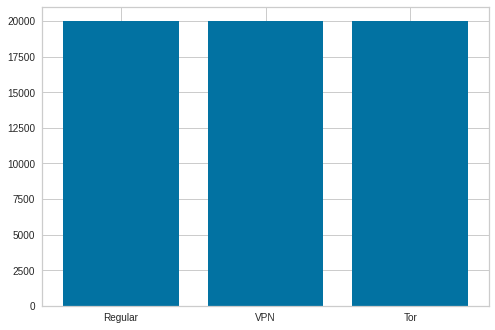

In [41]:
ratio_dict = {"VPN": 20000, "Regular": 20000, "Tor": 20000}
fake_df_traffic_2 = create_and_visualize_smote(utils.pd.concat([regular_experiment_2['Dataset'],vpn_experiment_2['Dataset'],tor_experiment_2['Dataset']]), 'Traffic Type', ratio_dict)

In [42]:
fake_traffic_dataset_2: dict = utils.package_data_for_inspection_with_label(
    utils.prune_dataset(utils.package_data_for_inspection(fake_df_traffic_2), [] ), 
    'Fake_Traffic_Dataset_2_20_15_5'
)

fake_traffic_dataset_2['Dataset'].to_csv('./synthetic/smote_balanced_traffic_dataset_20_20_20.csv', index=False)


    Dataset statistics:
        Shape:				(60000, 63)
        Samples:			60000 
        Features:			63
    

        Shape:				(60000, 63)
        Samples:			60000 
        Features:			63
    


### Next is a 20,000 Regular, 15,000 VPN, and 5,000 Tor split

In [43]:
vpn_experiment_3 : utils.Model_data = create_and_filter_new_model(traffic_dataset, 'Traffic Type', 'VPN')
tor_experiment_3 : utils.Model_data = create_and_filter_new_model(traffic_dataset, 'Traffic Type', 'Tor')
regular_experiment_3 : utils.Model_data = create_and_filter_new_model(traffic_dataset, 'Traffic Type', 'Regular')

regular_experiment_3['Dataset']  = downsample(regular_experiment_3['Dataset'], 'Traffic Type', 20000)
vpn_experiment_3['Dataset']  = downsample(vpn_experiment_3['Dataset'], 'Traffic Type', 15000)

Class=Regular, n=20000 (50.000%)
Class=VPN, n=15000 (37.500%)
Class=Tor, n=5000 (12.500%)


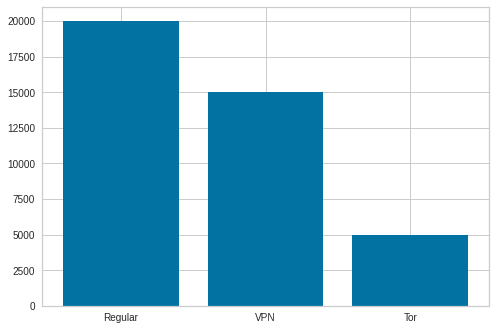

In [44]:
ratio_dict = {"VPN": 15000, "Regular": 20000, "Tor": 5000}
fake_df_traffic_3 = create_and_visualize_smote(utils.pd.concat([regular_experiment_3['Dataset'],vpn_experiment_3['Dataset'],tor_experiment_3['Dataset']]), 'Traffic Type', ratio_dict)

In [50]:
fake_traffic_dataset_3: dict = utils.package_data_for_inspection_with_label(
    utils.prune_dataset(utils.package_data_for_inspection(fake_df_traffic_3), [] ), 
    'Fake_Traffic_Dataset_3_20_15_5'
)

fake_traffic_dataset_3['Dataset'].to_csv('./synthetic/smote_balanced_traffic_dataset_labels_20_15_5.csv', index=False)


    Dataset statistics:
        Shape:				(40000, 63)
        Samples:			40000 
        Features:			63
    

        Shape:				(40000, 63)
        Samples:			40000 
        Features:			63
    


### Finally is a 30,000 Regular, 20,000 VPN, and 10,000 Tor split

In [48]:
vpn_experiment_4 : utils.Model_data = create_and_filter_new_model(traffic_dataset, 'Traffic Type', 'VPN')
tor_experiment_4 : utils.Model_data = create_and_filter_new_model(traffic_dataset, 'Traffic Type', 'Tor')
regular_experiment_4 : utils.Model_data = create_and_filter_new_model(traffic_dataset, 'Traffic Type', 'Regular')

regular_experiment_4['Dataset']  = downsample(regular_experiment_4['Dataset'], 'Traffic Type', 30000)
vpn_experiment_4['Dataset']  = downsample(vpn_experiment_4['Dataset'], 'Traffic Type', 20000)

Class=Regular, n=30000 (50.000%)
Class=VPN, n=20000 (33.333%)
Class=Tor, n=10000 (16.667%)


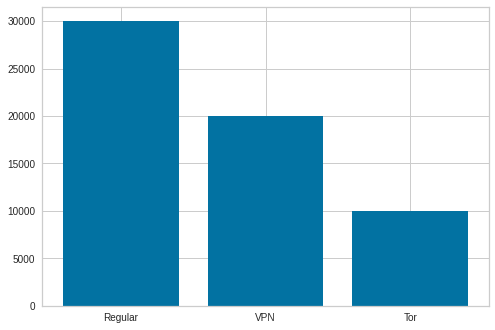

In [49]:
ratio_dict = {"VPN": 20000, "Regular": 30000, "Tor": 10000}
fake_df_traffic_4 = create_and_visualize_smote(utils.pd.concat([regular_experiment_4['Dataset'],vpn_experiment_4['Dataset'],tor_experiment_4['Dataset']]), 'Traffic Type', ratio_dict)

In [80]:
fake_traffic_dataset_4: dict = utils.package_data_for_inspection_with_label(
    utils.prune_dataset(utils.package_data_for_inspection(fake_df_traffic_4), [] ), 
    'Fake_Traffic_Dataset_4_30_20_10'
)

fake_traffic_dataset_4['Dataset'].to_csv('./synthetic/smote_balanced_traffic_dataset_labels_30_20_10.csv', index=False)


    Dataset statistics:
        Shape:				(60000, 63)
        Samples:			60000 
        Features:			63
    

        Shape:				(60000, 63)
        Samples:			60000 
        Features:			63
    


# Application Type Synthetic Data Generation


In [78]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def downsample_and_run_smote(dataset : dict, ratio_dict: dict, target_label: str) -> utils.pd.DataFrame:
    models : list = []
    df : Dataframe = utils.pd.DataFrame()
    for key, value in ratio_dict.items():
        models.append(create_and_filter_new_model(dataset, target_label, key))
        if len(models[-1]['Dataset']) > value:
            models[-1]['Dataset'] = downsample(models[-1]['Dataset'], target_label, value)
        df = df.append(models[-1]['Dataset'])
    return create_and_visualize_smote(df, target_label, ratio_dict)

### All application types with 10,000 samples

Class=audio-streaming, n=10000 (12.500%)
Class=browsing, n=10000 (12.500%)
Class=chat, n=10000 (12.500%)
Class=file-transfer, n=10000 (12.500%)
Class=email, n=10000 (12.500%)
Class=p2p, n=10000 (12.500%)
Class=video-streaming, n=10000 (12.500%)
Class=voip, n=10000 (12.500%)


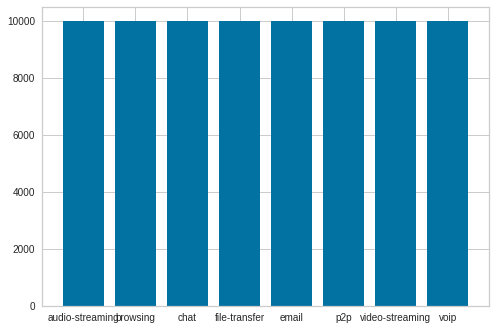


    Dataset statistics:
        Shape:				(80000, 63)
        Samples:			80000 
        Features:			63
    

        Shape:				(80000, 63)
        Samples:			80000 
        Features:			63
    


In [84]:
fake_df_application_2 = downsample_and_run_smote(application_dataset, {"audio-streaming": 10000, "browsing": 10000, "chat": 10000, "file-transfer": 10000, "email": 10000,
                                                                       "p2p": 10000, "video-streaming": 10000, "voip": 10000}, 'Application Type')

fake_application_dataset_2: dict = utils.package_data_for_inspection_with_label(
    utils.prune_dataset(utils.package_data_for_inspection(fake_df_application_2), [] ), 
    'Fake_Application_Dataset_2_10_10_10'
)

fake_application_dataset_2['Dataset'].to_csv('./synthetic/smote_balanced_application_dataset_labels_10_10_10.csv', index=False)

### All application types with 15,000 samples

Class=audio-streaming, n=15000 (12.500%)
Class=browsing, n=15000 (12.500%)
Class=chat, n=15000 (12.500%)
Class=file-transfer, n=15000 (12.500%)
Class=email, n=15000 (12.500%)
Class=p2p, n=15000 (12.500%)
Class=video-streaming, n=15000 (12.500%)
Class=voip, n=15000 (12.500%)


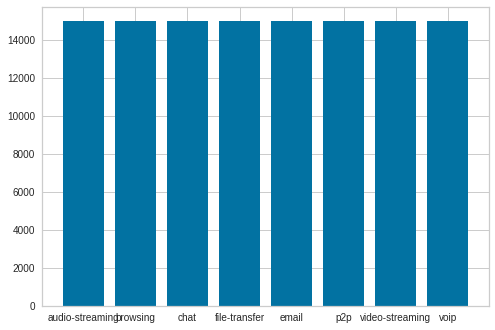


    Dataset statistics:
        Shape:				(120000, 63)
        Samples:			120000 
        Features:			63
    

        Shape:				(120000, 63)
        Samples:			120000 
        Features:			63
    


In [86]:
fake_df_application_3 = downsample_and_run_smote(application_dataset, {"audio-streaming": 15000, "browsing": 15000, "chat": 15000, "file-transfer": 15000, "email": 15000,
                                                                       "p2p": 15000, "video-streaming": 15000, "voip": 15000}, 'Application Type')

fake_application_dataset_3: dict = utils.package_data_for_inspection_with_label(
    utils.prune_dataset(utils.package_data_for_inspection(fake_df_application_3), [] ), 
    'Fake_Application_Dataset_3_15_15_15'
)

fake_application_dataset_3['Dataset'].to_csv('./synthetic/smote_balanced_application_dataset_labels_15_15_15.csv', index=False)

### All application types with 20,000 samples

Class=audio-streaming, n=20000 (12.500%)
Class=browsing, n=20000 (12.500%)
Class=chat, n=20000 (12.500%)
Class=file-transfer, n=20000 (12.500%)
Class=email, n=20000 (12.500%)
Class=p2p, n=20000 (12.500%)
Class=video-streaming, n=20000 (12.500%)
Class=voip, n=20000 (12.500%)


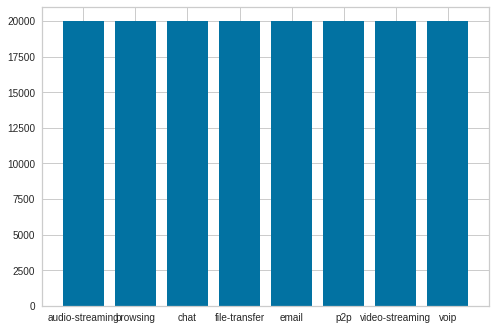


    Dataset statistics:
        Shape:				(160000, 63)
        Samples:			160000 
        Features:			63
    

        Shape:				(160000, 63)
        Samples:			160000 
        Features:			63
    


In [87]:
fake_df_application_4 = downsample_and_run_smote(application_dataset, {"audio-streaming": 20000, "browsing": 20000, "chat": 20000, "file-transfer": 20000, "email": 20000,
                                                                       "p2p": 20000, "video-streaming": 20000, "voip": 20000}, 'Application Type')

fake_application_dataset_4: dict = utils.package_data_for_inspection_with_label(
    utils.prune_dataset(utils.package_data_for_inspection(fake_df_application_4), [] ), 
    'Fake_Application_Dataset_4_20_20_20'
)

fake_application_dataset_4['Dataset'].to_csv('./synthetic/smote_balanced_application_dataset_labels_20_20_20.csv', index=False)

### All application types with 25,000 samples

Class=audio-streaming, n=25000 (12.500%)
Class=browsing, n=25000 (12.500%)
Class=chat, n=25000 (12.500%)
Class=file-transfer, n=25000 (12.500%)
Class=email, n=25000 (12.500%)
Class=p2p, n=25000 (12.500%)
Class=video-streaming, n=25000 (12.500%)
Class=voip, n=25000 (12.500%)


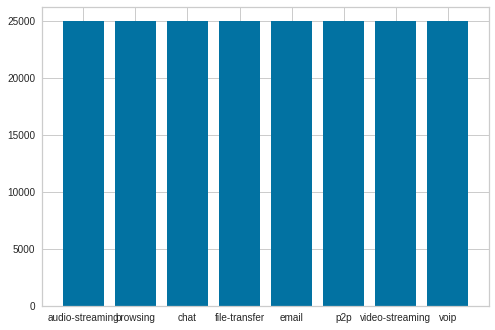


    Dataset statistics:
        Shape:				(200000, 63)
        Samples:			200000 
        Features:			63
    

        Shape:				(200000, 63)
        Samples:			200000 
        Features:			63
    


In [88]:
fake_df_application_5 = downsample_and_run_smote(application_dataset, {"audio-streaming": 25000, "browsing": 25000, "chat": 25000, "file-transfer": 25000, "email": 25000,
                                                                       "p2p": 25000, "video-streaming": 25000, "voip": 25000}, 'Application Type')

fake_application_dataset_5: dict = utils.package_data_for_inspection_with_label(
    utils.prune_dataset(utils.package_data_for_inspection(fake_df_application_5), [] ), 
    'Fake_Application_Dataset_5_25_25_25'
)

fake_application_dataset_5['Dataset'].to_csv('./synthetic/smote_balanced_application_dataset_labels_25_25_25.csv', index=False)

### All application types with 30,000 samples

Class=audio-streaming, n=30000 (12.500%)
Class=browsing, n=30000 (12.500%)
Class=chat, n=30000 (12.500%)
Class=file-transfer, n=30000 (12.500%)
Class=email, n=30000 (12.500%)
Class=p2p, n=30000 (12.500%)
Class=video-streaming, n=30000 (12.500%)
Class=voip, n=30000 (12.500%)


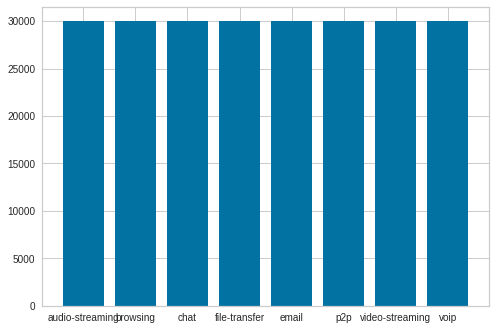


    Dataset statistics:
        Shape:				(240000, 63)
        Samples:			240000 
        Features:			63
    

        Shape:				(240000, 63)
        Samples:			240000 
        Features:			63
    


In [89]:
fake_df_application_6 = downsample_and_run_smote(application_dataset, {"audio-streaming": 30000, "browsing": 30000, "chat": 30000, "file-transfer": 30000, "email": 30000,
                                                                       "p2p": 30000, "video-streaming": 30000, "voip": 30000}, 'Application Type')

fake_application_dataset_6: dict = utils.package_data_for_inspection_with_label(
    utils.prune_dataset(utils.package_data_for_inspection(fake_df_application_6), [] ), 
    'Fake_Application_Dataset_6_30_30_30'
)

fake_application_dataset_6['Dataset'].to_csv('./synthetic/smote_balanced_application_dataset_labels_30_30_30.csv', index=False)

### Proportional Splits

Class=audio-streaming, n=9000 (10.000%)
Class=browsing, n=16000 (17.778%)
Class=chat, n=10000 (11.111%)
Class=file-transfer, n=10000 (11.111%)
Class=email, n=10000 (11.111%)
Class=p2p, n=20000 (22.222%)
Class=video-streaming, n=10000 (11.111%)
Class=voip, n=5000 (5.556%)


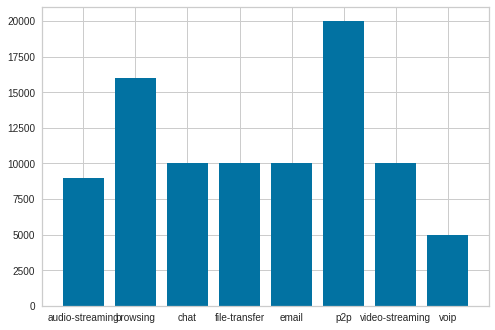


    Dataset statistics:
        Shape:				(240000, 63)
        Samples:			240000 
        Features:			63
    

        Shape:				(240000, 63)
        Samples:			240000 
        Features:			63
    


In [90]:
fake_df_application_7 = downsample_and_run_smote(application_dataset, {"audio-streaming": 9000, "browsing": 16000, "chat": 10000, "file-transfer": 10000, "email": 10000,
                                                                       "p2p": 20000, "video-streaming": 10000, "voip": 5000}, 'Application Type')

fake_application_dataset_7: dict = utils.package_data_for_inspection_with_label(
    utils.prune_dataset(utils.package_data_for_inspection(fake_df_application_6), [] ), 
    'Fake_Application_Dataset_7_proportional'
)

fake_application_dataset_7['Dataset'].to_csv('./synthetic/smote_balanced_application_dataset_labels_proportional.csv', index=False)

In [91]:
print(f'Last Execution: {utils.datetime.datetime.now()}')
assert False, 'Nothing after this point is included in the study'

Last Execution: 2022-04-03 12:45:26.816477


AssertionError: Nothing after this point is included in the study